In [1]:
!mkdir 'newdata'
!wget 'https://www.dropbox.com/s/xdy5cfu7m63pk46/?dl=1' -O ROD-synROD.tar
!tar -xf "ROD-synROD.tar" -C "newdata/"

--2022-09-04 11:44:15--  https://www.dropbox.com/s/xdy5cfu7m63pk46/?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/xdy5cfu7m63pk46 [following]
--2022-09-04 11:44:15--  https://www.dropbox.com/s/dl/xdy5cfu7m63pk46
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc808ad1d5905634b6efde20417d.dl-eu.dropboxusercontent.com/cd/0/get/BsQ3WE6G-WMG0Exz01j7yZ-vVOkAp6bqjLGZzKld4JMs_ER-GWPnormEn_la6k9vhQuNgNWoOgohhMt17B8IhCQzVXP3NifHTsAFOkwawdG0U_RscRPa8TYNUz9HlBhe7-M81sOwHP9uz0rgAe4PyGie1RLQHEalQRz3RC3ePVhmvglRAntg8OYuBXjXwzg0FkQ/file?dl=1# [following]
--2022-09-04 11:44:15--  https://uc808ad1d5905634b6efde20417d.dl-eu.dropboxusercontent.com/cd/0/get/BsQ3WE6G-WMG0Exz01j7yZ-vVOkAp6bqjLGZzKld4JMs_ER-GWPnormEn_la6k9vhQuNgNWoOgohhMt17B8IhC

In [2]:
from __future__ import print_function, division
import os

import torch
import pandas as pd
import torchvision

from NeuralNetwork import ResBase, MainHead, RotationHead
from torchvision import transforms
from torch.utils.data import DataLoader
import time
import copy
import torch.nn as nn
import torch.optim as optim
from itertools import permutations
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset
import random

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, paths_c, paths_d, img_dir, DoRot=False, labels="",
                 transform=None, ROD=False, Jigsaw=False):
        self.paths_c = paths_c
        self.paths_d = paths_d
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform
        self.DoRot = DoRot
        self.Jigsaw = Jigsaw
        self.ROD = ROD

    def __len__(self):
        return len(self.paths_c)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.ROD:
            rgb_path = os.path.join(self.img_dir, "rgb-washington/", self.paths_c.values[idx])
            depth_path = os.path.join(self.img_dir, "surfnorm-washington/", self.paths_d.values[idx])
            image_c = Image.open(rgb_path)
            image_d = Image.open(depth_path)
        else:
            rgb_path = os.path.join(self.img_dir, self.paths_c[idx])
            depth_path = os.path.join(self.img_dir, self.paths_d[idx])
            image_c = Image.open(rgb_path)
            image_d = Image.open(depth_path)
        if self.DoRot:
            z = random.choice((0, 1, 2, 3))
        elif self.Jigsaw:
            z = len(perms) - 1
            z = random.randint(0, z)
        else:
            z = 0
        if self.img_labels != "" and self.img_labels != []:
            label = self.img_labels[idx]
        else:
            label = 0
        if self.transform:
            image_c, image_d = scale(image_c, image_d)
            image_c, image_d = crop(image_c, image_d)
            image_c, image_d = tensor(image_c, image_d)
            transforms.Normalize(mean, std, inplace=True)(image_c)
            transforms.Normalize(mean, std, inplace=True)(image_d)
        x = torch.cat((image_c, image_d), 0)
        return x, label, z

In [4]:
perms = list(permutations(range(4)))
mean = [0.485, 0.456, 0.40]
std = [0.229, 0.224, 0.225]


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image_c, image_d):

        h1, w1 = image_c.height, image_c.width
        h2, w2 = image_d.height, image_d.width
        if isinstance(self.output_size, int):
            if h1 > w1:
                new_h1, new_w1 = self.output_size * h1 / w1, self.output_size
            else:
                new_h1, new_w1 = self.output_size, self.output_size * w1 / h1
            if h2 > w2:
                new_h2, new_w2 = self.output_size * h2 / w2, self.output_size
            else:
                new_h2, new_w2 = self.output_size, self.output_size * w2 / h2
        else:
            new_h1, new_w1 = self.output_size
            new_h2, new_w2 = self.output_size

        new_h1, new_w1 = int(new_h1), int(new_w1)
        new_h2, new_w2 = int(new_h2), int(new_w2)

        img1 = image_c.resize((new_h1, new_w1))
        img2 = image_d.resize((new_h2, new_w2))

        return img1, img2


class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image_c, image_d):
        h1, w1 = image_c.height, image_c.width
        h2, w2 = image_d.height, image_d.width

        new_h1, new_w1 = self.output_size
        new_h2, new_w2 = self.output_size

        top1 = np.random.randint(0, h1 - new_h1)
        left1 = np.random.randint(0, w1 - new_w1)
        top2 = np.random.randint(0, h2 - new_h2)
        left2 = np.random.randint(0, w2 - new_w2)

        img1 = image_c.crop((left1, h1 - new_h1, left1 + new_w1, h1))
        img2 = image_d.crop((left2, h2 - new_h2, left2 + new_w2, h2))

        return img1, img2


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image_c, image_d):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img1 = transforms.ToTensor()(image_c)
        img2 = transforms.ToTensor()(image_d)
        return img1, img2


scale = Rescale(256)
crop = RandomCrop(224)
tensor = ToTensor()

In [5]:
def make_jigsaw(img, z):
    img0 = img.to('cpu')
    img1 = img0[0:3].numpy().transpose((1, 2, 0))
    img2 = img0[3:6].numpy().transpose((1, 2, 0))
    newTiles = np.zeros((2, 4, 112, 112, 3))
    result = [0] * 2
    for i, im in zip([0, 1], [img1, img2]):
        M = im.shape[0] // 2
        N = im.shape[1] // 2
        tiles = [im[x:x + M, y:y + N] for x in range(0, im.shape[0], M) for y in
                 range(0, im.shape[1], N)]  # top, right, left, bottom
        shuffle_idx = perms[z]
        j = 0
        for slice in shuffle_idx:
            newTiles[i][j] = tiles[slice]
            j += 1
        img_p1 = np.concatenate([newTiles[i][0], newTiles[i][1]])
        img_p2 = np.concatenate([newTiles[i][2], newTiles[i][3]])
        result[i] = np.concatenate([img_p1, img_p2], 1)
    result = tensor(result[0], result[1])
    img = torch.cat((result[0], result[1]))
    return img

In [6]:
def prep_data(type, batch_size):
    # prepare data
    df_synROD_train = pd.read_csv('newdata/ROD-synROD/synROD/synARID_50k-split_sync_train1.txt',
                                  delimiter=' ', header=0, names=['File', 'Label'])
    df_synROD_test = pd.read_csv('newdata/ROD-synROD/synROD/synARID_50k-split_sync_test1.txt',
                                 delimiter=' ', header=0, names=['File', 'Label'])
    df_ROD_train = pd.read_csv('newdata/ROD-synROD/ROD/wrgbd_40k-split_sync.txt',
                               delimiter=' ', header=0, names=['File', 'Label'])

    train_synROD = dict(RGBfile=[], Dfile=[], Label=[])
    test_synROD = dict(RGBfile=[], Dfile=[], Label=[])
    train_ROD = dict(RGBfile=[], Dfile=[], Label=[])
    test_ROD = dict(RGBfile=[], Dfile=[])

    train_synROD["RGBfile"] = (df_synROD_train["File"].apply(lambda x: x.replace("***", "rgb"))).map(str)
    train_synROD["Dfile"] = (df_synROD_train["File"].apply(lambda x: x.replace("***", "depth"))).map(str)
    train_synROD["Label"] = df_synROD_train["Label"].values.tolist()

    test_synROD["RGBfile"] = (df_synROD_test["File"].apply(lambda x: x.replace("***", "rgb"))).map(str)
    test_synROD["Dfile"] = (df_synROD_test["File"].apply(lambda x: x.replace("***", "depth"))).map(str)
    test_synROD["Label"] = df_synROD_test["Label"].values.tolist()

    train_ROD["RGBfile"] = (df_ROD_train["File"].apply(lambda x: x.replace("***", "crop"))).map(str)
    train_ROD["Dfile"] = (df_ROD_train["File"].apply(lambda x: x.replace("***", "depthcrop"))).map(str)

    test_ROD["RGBfile"] = (df_ROD_train["File"].apply(lambda x: x.replace("***", "crop"))).map(str)
    test_ROD["Dfile"] = (df_ROD_train["File"].apply(lambda x: x.replace("***", "depthcrop"))).map(str)
    test_ROD["Label"] = df_ROD_train["Label"].values.tolist()

    if type == 'Jigsaw':
        training_data_synROD = CustomImageDataset(train_synROD["RGBfile"], train_synROD["Dfile"],
                                                  img_dir="newdata/ROD-synROD/synROD/",
                                                  labels=train_synROD["Label"],
                                                  transform=True, ROD=False, Jigsaw=True)

        RGB_train, RGB_test, label_train, label_test = train_test_split(test_ROD["RGBfile"], test_ROD["Label"],
                                                                        test_size=0.3, random_state=42)
        D_train, D_test, _, _ = train_test_split(test_ROD["Dfile"], test_ROD["Label"], test_size=0.3, random_state=42)
        test_data = CustomImageDataset(RGB_test, D_test, img_dir="newdata/ROD-synROD/ROD/",
                                       labels=label_test, transform=True, ROD=True, Jigsaw=True)
        training_data_ROD = CustomImageDataset(RGB_train, D_train, img_dir="newdata/ROD-synROD/ROD/",
                                               transform=True, ROD=True, Jigsaw=True)
        train_dataloader_synROD = DataLoader(training_data_synROD, batch_size=batch_size, shuffle=True, pin_memory=True,
                                             num_workers=2, drop_last=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2,
                                     drop_last=True)
        dataloaders = dict(train=train_dataloader_synROD, val=test_dataloader)
    elif type == 'Rotation':

        training_data_synROD = CustomImageDataset(train_synROD["RGBfile"], train_synROD["Dfile"], DoRot=True,
                                                  img_dir="newdata/ROD-synROD/synROD/",
                                                  labels=train_synROD["Label"],
                                                  transform=True, ROD=False)

        RGB_train, RGB_test, label_train, label_test = train_test_split(test_ROD["RGBfile"], test_ROD["Label"],
                                                                        test_size=0.3, random_state=42)
        D_train, D_test, _, _ = train_test_split(test_ROD["Dfile"], test_ROD["Label"],
                                                 test_size=0.3, random_state=42)
        test_data = CustomImageDataset(RGB_test, D_test, DoRot=False,
                                       img_dir="newdata/ROD-synROD/ROD/", labels=label_test,
                                       transform=True, ROD=True)
        training_data_ROD = CustomImageDataset(RGB_train, D_train, DoRot=True,
                                               img_dir="newdata/ROD-synROD/ROD/", transform=True, ROD=True)
        train_dataloader_synROD = DataLoader(training_data_synROD, batch_size=batch_size, shuffle=True, pin_memory=True,
                                             num_workers=2, drop_last=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2,
                                     drop_last=True)
        dataloaders = dict(train=train_dataloader_synROD, val=test_dataloader)
    else:
        training_data_e2e = CustomImageDataset(train_synROD["RGBfile"], train_synROD["Dfile"], DoRot=False,
                                               img_dir="newdata/ROD-synROD/synROD/", labels=train_synROD["Label"],
                                               transform=True, ROD=False)
        test_data_e2e = CustomImageDataset(test_ROD["RGBfile"], test_ROD["Dfile"], DoRot=False,
                                           img_dir="newdata/ROD-synROD/ROD/", labels=test_ROD["Label"],
                                           transform=True, ROD=True)
        training_data_ROD = CustomImageDataset(train_ROD["RGBfile"], train_ROD["Dfile"], DoRot=True,
                                               img_dir="newdata/ROD-synROD/ROD/", transform=True, ROD=True)

        train_dataloader_e2e = DataLoader(training_data_e2e, batch_size=batch_size, shuffle=True, pin_memory=True,
                                          num_workers=4, drop_last=True)
        test_dataloader_e2e = DataLoader(test_data_e2e, batch_size=batch_size, shuffle=True, pin_memory=True,
                                         num_workers=4, drop_last=True)
        dataloaders = dict(train=train_dataloader_e2e, val=test_dataloader_e2e)

    train_dataloader_ROD = DataLoader(training_data_ROD, batch_size=batch_size, shuffle=True, pin_memory=True,
                                      num_workers=0, drop_last=True)

    return dataloaders, train_dataloader_ROD

In [11]:
def train_model_DA(params, mode="Rotation"):
    num_epochs, batch_size, lr, weight_decay, momentum = params.get('num_epochs'), params.get('batch_size'), params.get('lr'), params.get('weight_decay'), params.get('momentum')
    FE_rgb = ResBase()
    FE_depth = ResBase()
    FC_M = MainHead(input_dim=512 * 2, class_num=47, dropout_p=0.5, extract=False)
    if mode == "Rotation":
        FC_P = RotationHead(input_dim=1024, class_num=4)
        dataloaders, target_dataloader = prep_data('Rotation', batch_size)
    elif mode == "Jigsaw":
        FC_P = RotationHead(input_dim=1024, class_num=24)
        dataloaders, target_dataloader = prep_data('Jigsaw', batch_size)
    else:
        FC_P = RotationHead(input_dim=1024, class_num=4)
        dataloaders, _ = prep_data('Source', batch_size)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    FE_rgb, FE_depth, FC_M, FC_P = FE_rgb.to(device), FE_depth.to(device), FC_M.to(device), FC_P.to(device)
    criterion = nn.CrossEntropyLoss()
    pretext_weight = 0.1
    optimizers = [optim.SGD(FE_rgb.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum),
                  optim.SGD(FE_depth.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum),
                  optim.SGD(FC_M.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum),
                  optim.SGD(FC_P.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)]
    since = time.time()
    best_model_wts = copy.deepcopy(FE_rgb.state_dict())
    best_acc = 0.0

    # Store losses and accuracies across epochs
    losses, accuracies, lr = dict(train=[], val=[]), dict(train=[], val=[]), 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                FE_rgb.train()
                FE_depth.train()
                FC_M.train()
                FC_P.train()
            else:
                FE_rgb.eval()
                FE_depth.eval()
                FC_M.eval()
                FC_P.eval()

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            nsamples = 0
            for x_source, y_source, z_source in dataloaders[phase]:  # Loading mini-batch from S
                # Load mini-batch from S
                x_source, y_source = x_source.to(device), y_source.to(device)
                nsamples += x_source.shape[0]
                for optimizer in optimizers:
                    optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Compute main loss Lm
                    # print_image(x_source[0])
                    feats_rgb, _ = FE_rgb(x_source[:, [0, 1, 2]])
                    feats_depth, _ = FE_depth(x_source[:, [3, 4, 5]])
                    feats = torch.cat((feats_rgb, feats_depth), dim=1)
                    pred_logits_cat = FC_M(feats)
                    _, preds_cat = torch.max(pred_logits_cat, 1)
                    Lm = criterion(pred_logits_cat, y_source)

                    if phase != 'val':
                        # Load mini-batches from S~ and T~
                        x_target, _, z_target = next(iter(target_dataloader))
                        # print_image(x_target[0])
                        # print_image(x_target[0])
                        # print_image(x_target_tilde[0])
                        x_target = x_target.to(device)

                        InTilde = torch.zeros(size=(batch_size, 6, 224, 224), device=device)
                        InZ = torch.zeros(size=[batch_size], device=device, dtype=torch.uint8)
                        for idx in range(0, batch_size, 2):
                            if mode == "Jigsaw":
                                InTilde[idx] = make_jigsaw(x_source[idx], z_source[idx].item())
                                InTilde[idx + 1] = make_jigsaw(x_target[idx], z_target[idx].item())
                            else:
                                rot_c = random.choice((0, 1, 2, 3))
                                rot_d = z_source[idx].item() + rot_c
                                if rot_d >= 4:
                                    rot_d -= 4
                                InTilde[idx][0:3] = transforms.functional.rotate(x_source[idx][0:3], rot_c * 90)
                                InTilde[idx][3:6] = transforms.functional.rotate(x_source[idx][3:6], rot_d * 90)
                                rot_c = random.choice((0, 1, 2, 3))
                                rot_d = z_target[idx].item() + rot_c
                                if rot_d > 4:
                                    rot_d -= 4
                                InTilde[idx + 1][0:3] = transforms.functional.rotate(x_target[idx][0:3], rot_c * 90)
                                InTilde[idx + 1][3:6] = transforms.functional.rotate(x_target[idx][3:6], rot_d * 90)
                            InZ[idx] = z_source[idx].data
                            InZ[idx + 1] = z_target[idx].data
                        # print_image(InTilde[0])
                        # print_image(InTilde[1])
                        _, feats_rgb = FE_rgb(InTilde[:, [0, 1, 2]])
                        _, feats_depth = FE_depth(InTilde[:, [3, 4, 5]])
                        feats = torch.cat((feats_rgb, feats_depth), dim=1)
                        pred_logits_rot = FC_P(feats)
                        _, preds_rot = torch.max(pred_logits_rot, 1)
                        Lp = criterion(pred_logits_rot, InZ)

                        # Cross-entropy minimization
                        L = Lm + (pretext_weight * Lp)
                    else:
                        L = Lm
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        L.backward()
                        for optimizer in optimizers:
                            optimizer.step()
                # statistics
                running_loss += Lm.item() * (len(x_source))
                running_corrects += (preds_cat == y_source.data).sum().item()
                #print('Phase: {} Progress: {}/{} Lm: {:.4f} Lp: {:.4f} L: {:.4f}'.format(phase, nsamples, dataloaders[
                #    phase].sampler.num_samples, Lm.item(), Lp.item(), L.item()))

            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            lr = optimizers[0].param_groups[0]['lr']
            print('Phase: {} LR: {:.4f} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, lr, epoch_loss, epoch_acc))
            if mode=="Rotation":
                with open('result_rotation.txt', 'a') as fp:
                    fp.write('Phase: {}, LR: {:.4f}, Loss: {:.4f}, Acc: {:.4f}\n'.format(phase, lr, epoch_loss, epoch_acc))
            else:
                with open('result_jigsaw.txt', 'a') as fp:
                    fp.write('Phase: {}, LR: {:.4f}, Loss: {:.4f}, Acc: {:.4f}\n'.format(phase, lr, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_FC_M_wts = copy.deepcopy(FC_M.state_dict())
                best_FC_P_wts = copy.deepcopy(FC_P.state_dict())
                best_FE_rgb_wts = copy.deepcopy(FE_rgb.state_dict())
                best_FE_depth_wts = copy.deepcopy(FE_depth.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    if mode=="Rotation":
        with open('result_rotation.txt', 'a') as fp:
            fp.write(('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60)))
            fp.write('Best val Acc: {:4f}\n'.format(best_acc))
    else:
        with open('result_jigsaw.txt', 'a') as fp:
            fp.write(('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60)))
            fp.write('Best val Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    if mode == "Rotation":
        save_filename = 'metrics_rotation.pth'
    else:
        save_filename = 'metrics_jigsaw.pth'
    save_path = os.path.join('./savedModels', save_filename)
    torch.save({
        'FE_rgb_state_dict': FE_rgb.state_dict(),
        'FE_depth_state_dict': FE_depth.state_dict(),
        'FC_M_state_dict': FC_M.state_dict()}, save_path)
    FC_M.load_state_dict(best_FC_M_wts)
    FC_P.load_state_dict(best_FC_P_wts)
    FE_rgb.load_state_dict(best_FE_rgb_wts)
    FE_depth.load_state_dict(best_FE_depth_wts)
    return (FE_rgb, FE_depth, FC_M, FC_P), losses, accuracies, lr

In [8]:
def train_model_source(params):
    num_epochs, batch_size, lr, weight_decay, momentum = params.get('num_epochs'), params.get('batch_size'), params.get(
        'lr'), params.get('weight_decay'), params.get('momentum')
    NN = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    NN.fc = nn.Linear(512, 47)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(NN.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    dataloaders, _ = prep_data("Source", batch_size)
    since = time.time()
    best_model_wts = copy.deepcopy(NN.state_dict())
    best_acc = 0.0
    # Store losses and accuracies across epochs
    losses, accuracies, lr = dict(train=[], val=[]), dict(train=[], val=[]), 0
    NN = NN.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                NN.train()  # Set model to training mode
            else:
                NN.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            nsamples = 0
            for x_source, y_source, _ in dataloaders[phase]:  # Loading mini-batch from S
                # Load mini-batch from S
                x_source, y_source = x_source.to(device, non_blocking=True), y_source.to(device, non_blocking=True)
                nsamples += x_source.shape[0]
                optimizer.zero_grad(set_to_none=True)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Compute main loss Lm
                    rgb, d = torch.tensor_split(x_source, 2, 1)
                    pred_logits_c = NN(rgb)
                    _, preds = torch.max(pred_logits_c, 1)
                    pred_logits_d = NN(d)
                    _, preds = torch.max(pred_logits_d, 1)
                    pred_logits = (pred_logits_c + pred_logits_d) / 2
                    L = criterion(pred_logits, y_source)
                    _, preds = torch.max(pred_logits, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        L.backward()
                        optimizer.step()

                # statistics
                running_loss += L.item() * len(x_source)
                running_corrects += torch.sum(preds == y_source.data).sum().item()
                #print('Phase: {} Progress: {}/{} Loss: {:.4f}'.format(phase, nsamples, dataloaders[
                #    phase].sampler.num_samples, L.item()))
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            lr = optimizer.param_groups[0]['lr']
            print('Phase: {}, LR: {:.4f}, Epoch Loss: {:.4f}, Epoch Accuracy: {:.4f}'.format(phase, lr, epoch_loss,
                                                                                             epoch_acc))
            with open('result_source.txt', 'a') as fp:
                fp.write('Phase: {}, LR: {:.4f}, Epoch Loss: {:.4f}, Epoch Accuracy: {:.4f}\n'.format(phase, lr, epoch_loss,
                                                                                             epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(NN.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    with open('result_source.txt', 'a') as fp:
        fp.write(('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60)))
        fp.write('Best val Acc: {:4f}\n'.format(best_acc))
    save_filename = 'metrics_source.pth'
    save_path = os.path.join('./savedModels', save_filename)
    torch.save({
        'model_state_dict': NN.state_dict()}, save_path)
    NN.load_state_dict(best_model_wts)
    return NN, losses, accuracies, lr

In [8]:
params = {'num_epochs': 20, 'batch_size': 64, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("End-to-end Source only training")
print("_______________________________")
model_source, losses_source, accuracies_source, lr_source = train_model_source(params)

End-to-end Source only training
_______________________________
Epoch 1/20
----------
Phase: train, LR: 0.0003, Epoch Loss: 2.9007, Epoch Accuracy: 0.3760
Phase: val, LR: 0.0003, Epoch Loss: 2.7316, Epoch Accuracy: 0.3508
Epoch 2/20
----------
Phase: train, LR: 0.0003, Epoch Loss: 1.6252, Epoch Accuracy: 0.6922
Phase: val, LR: 0.0003, Epoch Loss: 2.3532, Epoch Accuracy: 0.4496
Epoch 3/20
----------
Phase: train, LR: 0.0003, Epoch Loss: 1.2110, Epoch Accuracy: 0.7699
Phase: val, LR: 0.0003, Epoch Loss: 2.3205, Epoch Accuracy: 0.4419
Epoch 4/20
----------
Phase: train, LR: 0.0003, Epoch Loss: 1.0162, Epoch Accuracy: 0.8094
Phase: val, LR: 0.0003, Epoch Loss: 2.2845, Epoch Accuracy: 0.4577
Epoch 5/20
----------
Phase: train, LR: 0.0003, Epoch Loss: 0.9003, Epoch Accuracy: 0.8352
Phase: val, LR: 0.0003, Epoch Loss: 2.3900, Epoch Accuracy: 0.4296
Epoch 6/20
----------
Phase: train, LR: 0.0003, Epoch Loss: 0.8212, Epoch Accuracy: 0.8563
Phase: val, LR: 0.0003, Epoch Loss: 2.3925, Epoch Accur

In [10]:
params = {'num_epochs': 20, 'batch_size': 64, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using relative rotation for domain adaptation")
print("______________________________________________________")
models_rotation, losses_rotation, accuracies_rotation, lr_rotation = train_model_DA(params, mode="Rotation")

Training using relative rotation for domain adaptation
______________________________________________________


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------
Phase: train LR: 0.0003 Loss: 2.3496 Acc: 0.4259
Phase: val LR: 0.0003 Loss: 2.3124 Acc: 0.4090
Epoch 2/20
----------
Phase: train LR: 0.0003 Loss: 1.0252 Acc: 0.7611
Phase: val LR: 0.0003 Loss: 2.0529 Acc: 0.4691
Epoch 3/20
----------
Phase: train LR: 0.0003 Loss: 0.7736 Acc: 0.8339
Phase: val LR: 0.0003 Loss: 2.0676 Acc: 0.4566
Epoch 4/20
----------
Phase: train LR: 0.0003 Loss: 0.6638 Acc: 0.8697
Phase: val LR: 0.0003 Loss: 2.1179 Acc: 0.4527
Epoch 5/20
----------
Phase: train LR: 0.0003 Loss: 0.6060 Acc: 0.8911
Phase: val LR: 0.0003 Loss: 2.1072 Acc: 0.4645
Epoch 6/20
----------
Phase: train LR: 0.0003 Loss: 0.5740 Acc: 0.9056
Phase: val LR: 0.0003 Loss: 2.2061 Acc: 0.4463
Epoch 7/20
----------
Phase: train LR: 0.0003 Loss: 0.5545 Acc: 0.9173
Phase: val LR: 0.0003 Loss: 2.2419 Acc: 0.4413
Epoch 8/20
----------
Phase: train LR: 0.0003 Loss: 0.5433 Acc: 0.9275
Phase: val LR: 0.0003 Loss: 2.3180 Acc: 0.4480
Epoch 9/20
----------
Phase: train LR: 0.0003 Loss: 0.53

In [16]:
params = {'num_epochs': 20, 'batch_size': 64, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using jigsaw puzzle for domain adaptation")
print("__________________________________________________")
models_jigsaw, losses_jigsaw, accuracies_jigsaw, lr_jigsaw = train_model_DA(params, mode="Jigsaw")

Training using jigsaw puzzle for domain adaptation
__________________________________________________


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1/20
----------
Phase: train LR: 0.0003 Loss: 2.3012 Acc: 0.4309
Phase: val LR: 0.0003 Loss: 2.2655 Acc: 0.4121
Epoch 2/20
----------
Phase: train LR: 0.0003 Loss: 1.0177 Acc: 0.7620
Phase: val LR: 0.0003 Loss: 2.0225 Acc: 0.4820
Epoch 3/20
----------
Phase: train LR: 0.0003 Loss: 0.7673 Acc: 0.8355
Phase: val LR: 0.0003 Loss: 2.0002 Acc: 0.4922
Epoch 4/20
----------
Phase: train LR: 0.0003 Loss: 0.6624 Acc: 0.8682
Phase: val LR: 0.0003 Loss: 2.0608 Acc: 0.4780
Epoch 5/20
----------
Phase: train LR: 0.0003 Loss: 0.6054 Acc: 0.8912
Phase: val LR: 0.0003 Loss: 2.0771 Acc: 0.4824
Epoch 6/20
----------
Phase: train LR: 0.0003 Loss: 0.5705 Acc: 0.9059
Phase: val LR: 0.0003 Loss: 2.1587 Acc: 0.4606
Epoch 7/20
----------
Phase: train LR: 0.0003 Loss: 0.5529 Acc: 0.9177
Phase: val LR: 0.0003 Loss: 2.2010 Acc: 0.4722
Epoch 8/20
----------
Phase: train LR: 0.0003 Loss: 0.5441 Acc: 0.9266
Phase: val LR: 0.0003 Loss: 2.3112 Acc: 0.4406
Epoch 9/20
----------
Phase: train LR: 0.0003 Loss: 0.54

In [19]:
params = {'num_epochs': 10, 'batch_size': 128, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("End-to-end Source only training")
print("_______________________________")
model_source, losses_source, accuracies_source, lr_source = train_model_source(params)

End-to-end Source only training
_______________________________
Epoch 1/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 3.3725, Epoch Accuracy: 0.2345
Phase: val, LR: 0.0003, Epoch Loss: 3.2607, Epoch Accuracy: 0.2131
Epoch 2/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 2.3244, Epoch Accuracy: 0.5724
Phase: val, LR: 0.0003, Epoch Loss: 2.7455, Epoch Accuracy: 0.3511
Epoch 3/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 1.7202, Epoch Accuracy: 0.6813
Phase: val, LR: 0.0003, Epoch Loss: 2.4879, Epoch Accuracy: 0.4282
Epoch 4/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 1.4129, Epoch Accuracy: 0.7352
Phase: val, LR: 0.0003, Epoch Loss: 2.4099, Epoch Accuracy: 0.4381
Epoch 5/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 1.2252, Epoch Accuracy: 0.7688
Phase: val, LR: 0.0003, Epoch Loss: 2.3849, Epoch Accuracy: 0.4344
Epoch 6/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 1.0996, Epoch Accuracy: 0.7927
Phase: val, LR: 0.0003, Epoch Loss: 2.3329, Epoch Accur

In [20]:
params = {'num_epochs': 10, 'batch_size': 128, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using relative rotation for domain adaptation")
print("______________________________________________________")
models_rotation, losses_rotation, accuracies_rotation, lr_rotation = train_model_DA(params, mode="Rotation")

Training using relative rotation for domain adaptation
______________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 3.0158 Acc: 0.2615
Phase: val LR: 0.0003 Loss: 2.6198 Acc: 0.3489
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.4961 Acc: 0.6297
Phase: val LR: 0.0003 Loss: 2.2206 Acc: 0.4248
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 1.0701 Acc: 0.7510
Phase: val LR: 0.0003 Loss: 2.0848 Acc: 0.4564
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.8731 Acc: 0.8062
Phase: val LR: 0.0003 Loss: 2.0350 Acc: 0.4661
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.7639 Acc: 0.8380
Phase: val LR: 0.0003 Loss: 2.0451 Acc: 0.4677
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.6908 Acc: 0.8593
Phase: val LR: 0.0003 Loss: 2.0276 Acc: 0.4749
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.6406 Acc: 0.8750
Phase: val LR: 0.0003 Loss: 2.0478 Acc: 0.4768
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.6023 Acc: 

In [21]:
params = {'num_epochs': 10, 'batch_size': 128, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using jigsaw puzzle for domain adaptation")
print("__________________________________________________")
models_jigsaw, losses_jigsaw, accuracies_jigsaw, lr_jigsaw = train_model_DA(params, mode="Jigsaw")

Training using jigsaw puzzle for domain adaptation
__________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 2.9854 Acc: 0.2674
Phase: val LR: 0.0003 Loss: 2.6794 Acc: 0.3019
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.4907 Acc: 0.6308
Phase: val LR: 0.0003 Loss: 2.2734 Acc: 0.3969
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 1.0735 Acc: 0.7517
Phase: val LR: 0.0003 Loss: 2.1167 Acc: 0.4480
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.8814 Acc: 0.8035
Phase: val LR: 0.0003 Loss: 2.0838 Acc: 0.4466
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.7674 Acc: 0.8359
Phase: val LR: 0.0003 Loss: 2.0436 Acc: 0.4609
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.6938 Acc: 0.8592
Phase: val LR: 0.0003 Loss: 2.0366 Acc: 0.4712
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.6449 Acc: 0.8745
Phase: val LR: 0.0003 Loss: 2.0608 Acc: 0.4673
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.6038 Acc: 0.8859
P

In [23]:
params = {'num_epochs': 10, 'batch_size': 32, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("End-to-end Source only training")
print("_______________________________")
model_source, losses_source, accuracies_source, lr_source = train_model_source(params)

End-to-end Source only training
_______________________________
Epoch 1/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 2.3270, Epoch Accuracy: 0.5062
Phase: val, LR: 0.0003, Epoch Loss: 2.3969, Epoch Accuracy: 0.4161
Epoch 2/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 1.2037, Epoch Accuracy: 0.7603
Phase: val, LR: 0.0003, Epoch Loss: 2.2488, Epoch Accuracy: 0.4506
Epoch 3/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 0.9540, Epoch Accuracy: 0.8233
Phase: val, LR: 0.0003, Epoch Loss: 2.3689, Epoch Accuracy: 0.4352
Epoch 4/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 0.8420, Epoch Accuracy: 0.8592
Phase: val, LR: 0.0003, Epoch Loss: 2.3922, Epoch Accuracy: 0.4191
Epoch 5/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 0.7821, Epoch Accuracy: 0.8790
Phase: val, LR: 0.0003, Epoch Loss: 2.4654, Epoch Accuracy: 0.4084
Epoch 6/10
----------
Phase: train, LR: 0.0003, Epoch Loss: 0.7526, Epoch Accuracy: 0.8940
Phase: val, LR: 0.0003, Epoch Loss: 2.5268, Epoch Accur

In [24]:
params = {'num_epochs': 10, 'batch_size': 32, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using relative rotation for domain adaptation")
print("______________________________________________________")
models_rotation, losses_rotation, accuracies_rotation, lr_rotation = train_model_DA(params, mode="Rotation")

Training using relative rotation for domain adaptation
______________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 1.7626 Acc: 0.5644
Phase: val LR: 0.0003 Loss: 2.0625 Acc: 0.4714
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 0.7752 Acc: 0.8359
Phase: val LR: 0.0003 Loss: 2.1125 Acc: 0.4592
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 0.6437 Acc: 0.8854
Phase: val LR: 0.0003 Loss: 2.1919 Acc: 0.4727
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.6060 Acc: 0.9091
Phase: val LR: 0.0003 Loss: 2.2944 Acc: 0.4672
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.6040 Acc: 0.9241
Phase: val LR: 0.0003 Loss: 2.3739 Acc: 0.4539
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.6113 Acc: 0.9377
Phase: val LR: 0.0003 Loss: 2.4983 Acc: 0.4455
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.6300 Acc: 0.9460
Phase: val LR: 0.0003 Loss: 2.5766 Acc: 0.4229
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.6514 Acc: 

In [25]:
params = {'num_epochs': 10, 'batch_size': 32, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using jigsaw puzzle for domain adaptation")
print("__________________________________________________")
models_jigsaw, losses_jigsaw, accuracies_jigsaw, lr_jigsaw = train_model_DA(params, mode="Jigsaw")

Training using jigsaw puzzle for domain adaptation
__________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 1.7535 Acc: 0.5697
Phase: val LR: 0.0003 Loss: 1.9481 Acc: 0.4833
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 0.7894 Acc: 0.8313
Phase: val LR: 0.0003 Loss: 2.0596 Acc: 0.4555
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 0.6492 Acc: 0.8844
Phase: val LR: 0.0003 Loss: 2.1111 Acc: 0.4701
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.6146 Acc: 0.9073
Phase: val LR: 0.0003 Loss: 2.2083 Acc: 0.4634
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.6097 Acc: 0.9226
Phase: val LR: 0.0003 Loss: 2.3816 Acc: 0.4332
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.6168 Acc: 0.9362
Phase: val LR: 0.0003 Loss: 2.5474 Acc: 0.4081
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.6335 Acc: 0.9469
Phase: val LR: 0.0003 Loss: 2.6414 Acc: 0.4168
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.6532 Acc: 0.9545
P

In [27]:
params = {'num_epochs': 10, 'batch_size': 128, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using relative rotation for domain adaptation")
print("______________________________________________________")
models_rotation, losses_rotation, accuracies_rotation, lr_rotation = train_model_DA(params, mode="Rotation")

Training using relative rotation for domain adaptation
______________________________________________________


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 3.0177 Acc: 0.2665
Phase: val LR: 0.0003 Loss: 2.6167 Acc: 0.3165
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.4991 Acc: 0.6311
Phase: val LR: 0.0003 Loss: 2.1637 Acc: 0.4373
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 1.0699 Acc: 0.7512
Phase: val LR: 0.0003 Loss: 1.9991 Acc: 0.4888
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.8747 Acc: 0.8076
Phase: val LR: 0.0003 Loss: 1.9509 Acc: 0.5030
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.7681 Acc: 0.8344
Phase: val LR: 0.0003 Loss: 1.9504 Acc: 0.5090
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.6944 Acc: 0.8608
Phase: val LR: 0.0003 Loss: 1.9496 Acc: 0.5040
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.6456 Acc: 0.8728
Phase: val LR: 0.0003 Loss: 1.9735 Acc: 0.5064
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.6076 Acc: 0.8870
Phase: val LR: 0.0003 Loss: 2.0069 Acc: 0.5026
Epoch 9/10
----------
Phase: train LR: 0.0003 Loss: 0.58

In [28]:
params = {'num_epochs': 10, 'batch_size': 64, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using jigsaw puzzle for domain adaptation")
print("__________________________________________________")
models_jigsaw, losses_jigsaw, accuracies_jigsaw, lr_jigsaw = train_model_DA(params, mode="Jigsaw")

Training using jigsaw puzzle for domain adaptation
__________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 2.3203 Acc: 0.4323
Phase: val LR: 0.0003 Loss: 2.3327 Acc: 0.3806
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.0221 Acc: 0.7636
Phase: val LR: 0.0003 Loss: 2.1011 Acc: 0.4391
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 0.7727 Acc: 0.8347
Phase: val LR: 0.0003 Loss: 2.0252 Acc: 0.4653
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.6629 Acc: 0.8703
Phase: val LR: 0.0003 Loss: 2.1098 Acc: 0.4472
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.6082 Acc: 0.8895
Phase: val LR: 0.0003 Loss: 2.1559 Acc: 0.4521
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.5760 Acc: 0.9051
Phase: val LR: 0.0003 Loss: 2.2118 Acc: 0.4531
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.5572 Acc: 0.9153
Phase: val LR: 0.0003 Loss: 2.2498 Acc: 0.4459
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.5459 Acc: 0.9259
P

In [30]:
params = {'num_epochs': 10, 'batch_size': 128, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using relative rotation for domain adaptation")
print("______________________________________________________")
models_rotation, losses_rotation, accuracies_rotation, lr_rotation = train_model_DA(params, mode="Rotation")

Training using relative rotation for domain adaptation
______________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 3.0191 Acc: 0.2615
Phase: val LR: 0.0003 Loss: 2.6948 Acc: 0.3097
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.5110 Acc: 0.6249
Phase: val LR: 0.0003 Loss: 2.3040 Acc: 0.4120
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 1.0832 Acc: 0.7447
Phase: val LR: 0.0003 Loss: 2.1414 Acc: 0.4620
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.8899 Acc: 0.7996
Phase: val LR: 0.0003 Loss: 2.0708 Acc: 0.4759
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.7732 Acc: 0.8320
Phase: val LR: 0.0003 Loss: 2.0505 Acc: 0.4769
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.6998 Acc: 0.8568
Phase: val LR: 0.0003 Loss: 2.0504 Acc: 0.4867
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.6463 Acc: 0.8733
Phase: val LR: 0.0003 Loss: 2.0663 Acc: 0.4831
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.6114 Acc: 

In [32]:
params = {'num_epochs': 10, 'batch_size': 64, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using jigsaw puzzle for domain adaptation")
print("__________________________________________________")
models_jigsaw, losses_jigsaw, accuracies_jigsaw, lr_jigsaw = train_model_DA(params, mode="Jigsaw")

Training using jigsaw puzzle for domain adaptation
__________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 2.3186 Acc: 0.4283
Phase: val LR: 0.0003 Loss: 2.2226 Acc: 0.4131
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.0253 Acc: 0.7613
Phase: val LR: 0.0003 Loss: 2.0468 Acc: 0.4561
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 0.7692 Acc: 0.8385
Phase: val LR: 0.0003 Loss: 2.0439 Acc: 0.4649
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.6607 Acc: 0.8713
Phase: val LR: 0.0003 Loss: 2.0430 Acc: 0.4629
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.6051 Acc: 0.8914
Phase: val LR: 0.0003 Loss: 2.0826 Acc: 0.4634
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.5734 Acc: 0.9064
Phase: val LR: 0.0003 Loss: 2.1474 Acc: 0.4551
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.5528 Acc: 0.9182
Phase: val LR: 0.0003 Loss: 2.2217 Acc: 0.4441
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.5412 Acc: 0.9274
P

In [8]:
params = {'num_epochs': 10, 'batch_size': 128, 'lr': 3e-4, 'weight_decay': 0.04, 'momentum': 0.9}
print("Training using relative rotation for domain adaptation")
print("______________________________________________________")
models_rotation, losses_rotation, accuracies_rotation, lr_rotation = train_model_DA(params, mode="Rotation")

Training using relative rotation for domain adaptation
______________________________________________________


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 2.9781 Acc: 0.2674
Phase: val LR: 0.0003 Loss: 2.6882 Acc: 0.2896
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.4776 Acc: 0.6346
Phase: val LR: 0.0003 Loss: 2.2699 Acc: 0.3857
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 1.0554 Acc: 0.7488
Phase: val LR: 0.0003 Loss: 2.0923 Acc: 0.4349
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.8585 Acc: 0.8031
Phase: val LR: 0.0003 Loss: 2.0522 Acc: 0.4464
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.7388 Acc: 0.8383
Phase: val LR: 0.0003 Loss: 2.0429 Acc: 0.4468
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.6630 Acc: 0.8592
Phase: val LR: 0.0003 Loss: 2.0286 Acc: 0.4525
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.6118 Acc: 0.8741
Phase: val LR: 0.0003 Loss: 2.0389 Acc: 0.4515
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.5690 Acc: 0.8860
Phase: val LR: 0.0003 Loss: 2.0150 Acc: 0.4597
Epoch 9/10
----------
Phase: train LR: 0.0003 Loss: 0.54

In [10]:
params = {'num_epochs': 10, 'batch_size': 64, 'lr': 3e-4, 'weight_decay': 0.04, 'momentum': 0.9}
print("Training using jigsaw puzzle for domain adaptation")
print("__________________________________________________")
models_jigsaw, losses_jigsaw, accuracies_jigsaw, lr_jigsaw = train_model_DA(params, mode="Jigsaw")

Training using jigsaw puzzle for domain adaptation
__________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 2.3110 Acc: 0.4255
Phase: val LR: 0.0003 Loss: 2.2920 Acc: 0.3996
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.0155 Acc: 0.7581
Phase: val LR: 0.0003 Loss: 2.0610 Acc: 0.4602
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 0.7452 Acc: 0.8346
Phase: val LR: 0.0003 Loss: 2.0124 Acc: 0.4596
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.6298 Acc: 0.8681
Phase: val LR: 0.0003 Loss: 2.0675 Acc: 0.4505
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.5634 Acc: 0.8925
Phase: val LR: 0.0003 Loss: 2.0738 Acc: 0.4549
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.5206 Acc: 0.9064
Phase: val LR: 0.0003 Loss: 2.1433 Acc: 0.4364
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.4947 Acc: 0.9156
Phase: val LR: 0.0003 Loss: 2.1743 Acc: 0.4327
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.4730 Acc: 0.9276
P

In [12]:
params = {'num_epochs': 10, 'batch_size': 128, 'lr': 3e-4, 'weight_decay': 0.06, 'momentum': 0.9}
print("Training using relative rotation for domain adaptation")
print("______________________________________________________")
models_rotation, losses_rotation, accuracies_rotation, lr_rotation = train_model_DA(params, mode="Rotation")

Training using relative rotation for domain adaptation
______________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 3.0135 Acc: 0.2628
Phase: val LR: 0.0003 Loss: 2.6105 Acc: 0.3150
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.5118 Acc: 0.6306
Phase: val LR: 0.0003 Loss: 2.2332 Acc: 0.4074
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 1.0917 Acc: 0.7532
Phase: val LR: 0.0003 Loss: 2.0847 Acc: 0.4566
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.9026 Acc: 0.8064
Phase: val LR: 0.0003 Loss: 2.0366 Acc: 0.4787
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.7922 Acc: 0.8383
Phase: val LR: 0.0003 Loss: 2.0123 Acc: 0.4812
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.7229 Acc: 0.8621
Phase: val LR: 0.0003 Loss: 2.0240 Acc: 0.4861
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.6820 Acc: 0.8759
Phase: val LR: 0.0003 Loss: 2.0366 Acc: 0.4952
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.6454 Acc: 

In [14]:
params = {'num_epochs': 10, 'batch_size': 64, 'lr': 3e-4, 'weight_decay': 0.06, 'momentum': 0.9}
print("Training using jigsaw puzzle for domain adaptation")
print("__________________________________________________")
models_jigsaw, losses_jigsaw, accuracies_jigsaw, lr_jigsaw = train_model_DA(params, mode="Jigsaw")

Training using jigsaw puzzle for domain adaptation
__________________________________________________
Epoch 1/10
----------
Phase: train LR: 0.0003 Loss: 2.3010 Acc: 0.4370
Phase: val LR: 0.0003 Loss: 2.2591 Acc: 0.4035
Epoch 2/10
----------
Phase: train LR: 0.0003 Loss: 1.0199 Acc: 0.7714
Phase: val LR: 0.0003 Loss: 2.0788 Acc: 0.4487
Epoch 3/10
----------
Phase: train LR: 0.0003 Loss: 0.7849 Acc: 0.8417
Phase: val LR: 0.0003 Loss: 2.0738 Acc: 0.4567
Epoch 4/10
----------
Phase: train LR: 0.0003 Loss: 0.6893 Acc: 0.8735
Phase: val LR: 0.0003 Loss: 2.1181 Acc: 0.4580
Epoch 5/10
----------
Phase: train LR: 0.0003 Loss: 0.6465 Acc: 0.8926
Phase: val LR: 0.0003 Loss: 2.1984 Acc: 0.4492
Epoch 6/10
----------
Phase: train LR: 0.0003 Loss: 0.6244 Acc: 0.9083
Phase: val LR: 0.0003 Loss: 2.2606 Acc: 0.4437
Epoch 7/10
----------
Phase: train LR: 0.0003 Loss: 0.6169 Acc: 0.9187
Phase: val LR: 0.0003 Loss: 2.3365 Acc: 0.4447
Epoch 8/10
----------
Phase: train LR: 0.0003 Loss: 0.6226 Acc: 0.9269
P

In [10]:
params = {'num_epochs': 40, 'batch_size': 128, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using relative rotation for domain adaptation")
print("______________________________________________________")
models_rotation, losses_rotation, accuracies_rotation, lr_rotation = train_model_DA(params, mode="Rotation")

Training using relative rotation for domain adaptation
______________________________________________________
Epoch 1/40
----------
Phase: train LR: 0.0003 Loss: 2.9907 Acc: 0.2672
Phase: val LR: 0.0003 Loss: 2.6317 Acc: 0.3328
Epoch 2/40
----------
Phase: train LR: 0.0003 Loss: 1.5055 Acc: 0.6273
Phase: val LR: 0.0003 Loss: 2.2026 Acc: 0.4484
Epoch 3/40
----------
Phase: train LR: 0.0003 Loss: 1.0814 Acc: 0.7488
Phase: val LR: 0.0003 Loss: 2.0433 Acc: 0.4836
Epoch 4/40
----------
Phase: train LR: 0.0003 Loss: 0.8907 Acc: 0.8004
Phase: val LR: 0.0003 Loss: 1.9943 Acc: 0.5026
Epoch 5/40
----------
Phase: train LR: 0.0003 Loss: 0.7719 Acc: 0.8343
Phase: val LR: 0.0003 Loss: 1.9837 Acc: 0.4925
Epoch 6/40
----------
Phase: train LR: 0.0003 Loss: 0.6980 Acc: 0.8555
Phase: val LR: 0.0003 Loss: 1.9838 Acc: 0.4964
Epoch 7/40
----------
Phase: train LR: 0.0003 Loss: 0.6476 Acc: 0.8734
Phase: val LR: 0.0003 Loss: 1.9986 Acc: 0.4946
Epoch 8/40
----------
Phase: train LR: 0.0003 Loss: 0.6030 Acc: 

In [ ]:
params = {'num_epochs': 40, 'batch_size': 64, 'lr': 3e-4, 'weight_decay': 0.05, 'momentum': 0.9}
print("Training using jigsaw puzzle for domain adaptation")
print("__________________________________________________")
models_jigsaw, losses_jigsaw, accuracies_jigsaw, lr_jigsaw = train_model_DA(params, mode="Jigsaw")

Training using jigsaw puzzle for domain adaptation
__________________________________________________
Epoch 1/40
----------
Phase: train LR: 0.0003 Loss: 2.2908 Acc: 0.4296
Phase: val LR: 0.0003 Loss: 2.3533 Acc: 0.3475
Epoch 2/40
----------
Phase: train LR: 0.0003 Loss: 1.0136 Acc: 0.7657
Phase: val LR: 0.0003 Loss: 2.1412 Acc: 0.4102
Epoch 3/40
----------
Phase: train LR: 0.0003 Loss: 0.7623 Acc: 0.8383
Phase: val LR: 0.0003 Loss: 2.1064 Acc: 0.4365
Epoch 4/40
----------
Phase: train LR: 0.0003 Loss: 0.6579 Acc: 0.8724
Phase: val LR: 0.0003 Loss: 2.1135 Acc: 0.4410
Epoch 5/40
----------
Phase: train LR: 0.0003 Loss: 0.6008 Acc: 0.8914
Phase: val LR: 0.0003 Loss: 2.1865 Acc: 0.4354
Epoch 6/40
----------
Phase: train LR: 0.0003 Loss: 0.5694 Acc: 0.9079
Phase: val LR: 0.0003 Loss: 2.2217 Acc: 0.4314
Epoch 7/40
----------
Phase: train LR: 0.0003 Loss: 0.5511 Acc: 0.9187
Phase: val LR: 0.0003 Loss: 2.2750 Acc: 0.4338
Epoch 8/40
----------
Phase: train LR: 0.0003 Loss: 0.5424 Acc: 0.9286
P

In [13]:
def print_image(img):
    img0 = img.to('cpu')
    img1 = img0[0:3].numpy().transpose((1, 2, 0))
    img2 = img0[3:6].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.40])
    std = np.array([0.229, 0.224, 0.225])
    img1 = (std * img1 + mean)
    img1 = np.clip(img1, 0, 1)
    img2 = (std * img2 + mean)
    img2 = np.clip(img2, 0, 1)
    pil_image1 = Image.fromarray((img1 * 255).astype('uint8'))
    pil_image2 = Image.fromarray((img2 * 255).astype('uint8'))
    pil_image1.show()
    pil_image2.show()

Actual label: dry battery
Predicted label: dry battery


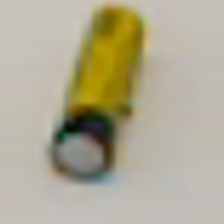

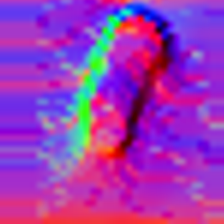

Actual label: ball
Predicted label: ball


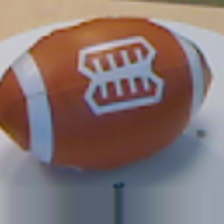

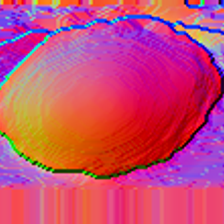

Actual label: toothpaste
Predicted label: toothpaste


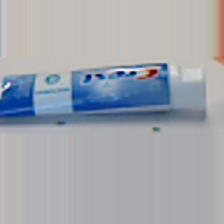

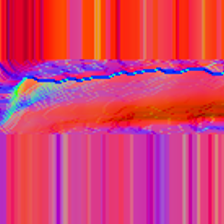

Actual label: lemon
Predicted label: lemon


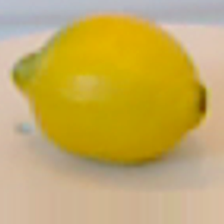

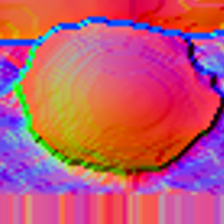

Actual label: food box
Predicted label: cereal box


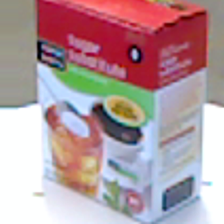

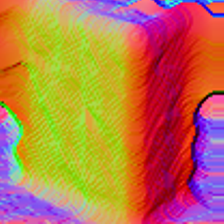

Actual label: pitcher
Predicted label: pitcher


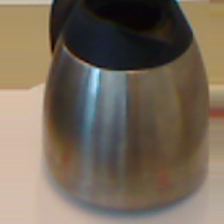

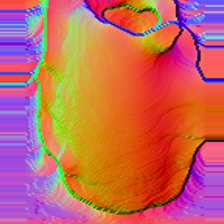

Actual label: pliers
Predicted label: scissors


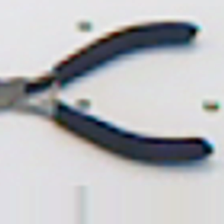

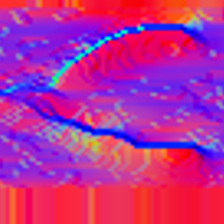

Actual label: cereal box
Predicted label: food box


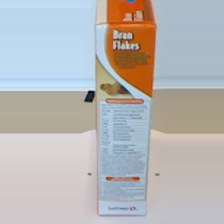

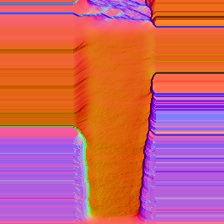

Actual label: pliers
Predicted label: scissors


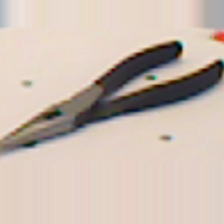

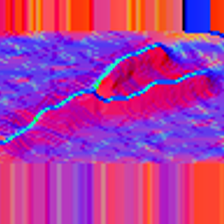

Actual label: food can
Predicted label: soda can


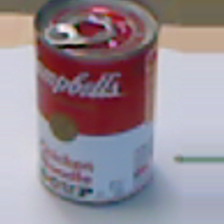

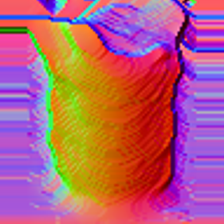

In [18]:
 category_dict = {
        0: 'apple', 1: 'ball', 2: 'banana', 3: 'bell pepper', 4: 'binder', 5: 'bowl', 6: 'calculator', 7: 'camera',
        8: 'cap',
        9: 'cell phone', 10: 'cereal box',
        11: 'coffee mug', 12: 'comb', 13: 'dry battery', 14: 'flashlight', 15: 'food bag', 16: 'food box',
        17: 'food can', 18: 'food cup',
        19: 'food jar', 20: 'garlic',
        21: 'glue stick', 22: 'greens', 23: 'hand towel', 24: 'instant noodles', 25: 'keyboard', 26: 'kleenex',
        27: 'lemon',
        28: 'light bulb', 29: 'marker', 30: 'mushroom',
        31: 'notebook', 32: 'orange', 33: 'pear', 34: 'pitcher', 35: 'plate', 36: 'pliers', 37: 'potato',
        38: 'rubber eraser', 39: 'scissors',
        40: 'shampoo',
        41: 'soda can', 42: 'sponge', 43: 'stapler', 44: 'toothbrush', 45: 'toothpaste', 46: 'water bottle'}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_dicts = torch.load('savedModels/metrics_rotation.pth')
FE_rgb = ResBase()
FE_depth = ResBase()
FC_M = MainHead(input_dim=512 * 2, class_num=47, dropout_p=0.5, extract=False)
FE_rgb.load_state_dict(model_dicts['FE_rgb_state_dict'])
FE_depth.load_state_dict(model_dicts['FE_depth_state_dict'])
FC_M.load_state_dict(model_dicts['FC_M_state_dict'])
FE_rgb, FE_depth, FC_M = FE_rgb.to(device), FE_depth.to(device), FC_M.to(device)
FE_rgb.eval()
FE_depth.eval()
FC_M.eval()
filename = 'newdata/ROD-synROD/ROD/wrgbd_40k-split_sync.txt'
df_ROD_train = pd.read_csv('newdata/ROD-synROD/ROD/wrgbd_40k-split_sync.txt',
                           delimiter=' ', header=0, names=['File', 'Label'])
test_ROD = dict(RGBfile=[], Dfile=[], Label=[])
test_ROD["RGBfile"] = (df_ROD_train["File"].apply(lambda x: x.replace("***", "crop"))).map(str)
test_ROD["Dfile"] = (df_ROD_train["File"].apply(lambda x: x.replace("***", "depthcrop"))).map(str)
test_ROD["Label"] = df_ROD_train["Label"].values.tolist()
test_data = CustomImageDataset(test_ROD["RGBfile"], test_ROD["Dfile"], DoRot=False,
                                   img_dir="newdata/ROD-synROD/ROD/", labels=test_ROD["Label"],
                                   transform=True, ROD=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True, pin_memory=True,
                                 num_workers=4, drop_last=True)
images, labels, _ = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)
feats_rgb, _ = FE_rgb(images[:, [0, 1, 2]])
feats_depth, _ = FE_depth(images[:, [3, 4, 5]])
feats = torch.cat((feats_rgb, feats_depth), dim=1)
pred_logits_cat = FC_M(feats)
_, predictions = torch.max(pred_logits_cat, 1)
for i, label, prediction in zip(range(0, 10), labels, predictions):
    print("Actual label:",category_dict.get(label.item()))
    print("Predicted label:",category_dict.get(prediction.item()))
    print_image(images[i, :])